## Load data

In [1]:
%autosave 5

#  Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

from keras.models import load_model
from keras.callbacks import TensorBoard
from datetime import datetime, timedelta

from scripts.utilities import *

np.random.seed(0)

Autosaving every 5 seconds


In [2]:
#  Load datasets
train = pd.read_csv('data/train_dataset.csv')
test = pd.read_csv('data/test_dataset.csv')

In [4]:
print(train.shape)
print(test.shape)

(541, 6)
(136, 6)


In [5]:
#  Group data into groups containing seven observations
train_data = create_groups(
    train['close_point_relative_normalization'][2:].values)

test_data = create_groups(
    test['close_point_relative_normalization'][:-3].values)

In [6]:
#  Reshape the data in the format expected by the LSTM layer
X_train, Y_train = split_lstm_input(train_data)

In [7]:
def train_model(model, X, Y, epochs, version, run_number):
    """Training a model with TensorBoard callback.

    This function names each run of the model
    using the TensorBoard naming conventions.

    Parameters
    ----------
    model: Keras model instance
        Compiled Keras model.

    X, Y: np.array
        Series of observations to be used in
        the training process.

    epochs: int
        The number of epochs to train the
        model for.

    version: int
        Version of the model to run.

    run_number: int
        The number of the run. Used in case
        the same model version is run again.
    """
    model_name = f'bitcoin_lstm_v{version}_run_{run_number}'
    tensorboard = TensorBoard(log_dir=f'./logs/{model_name}')

    model_history = model.fit(
        x=X, y=Y,
        batch_size=1, epochs=epochs,
        shuffle=False, callbacks=[tensorboard])

    return model_history

In [8]:
#  Load previously trained network
model = load_model('bitcoin_lstm_v0.h5')

In [9]:
#  Retrain model
train_model(model=model,
            X=X_train, Y=Y_train,
            epochs=100,
            version=0, run_number=1)

Epoch 1/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0039
Epoch 2/100
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 6/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 11/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 12/100
1/1 [==============================] - 0s 6ms/step - lo

1/1 [==============================] - 0s 3ms/step - loss: 2.7914e-06
Epoch 97/100
1/1 [==============================] - 0s 2ms/step - loss: 2.4430e-06
Epoch 98/100
1/1 [==============================] - 0s 3ms/step - loss: 2.2151e-06
Epoch 99/100
1/1 [==============================] - 0s 2ms/step - loss: 2.1591e-06
Epoch 100/100
1/1 [==============================] - 0s 2ms/step - loss: 2.2237e-06


## Evaluate LSTM model

In [10]:
#  Combine training and testing datasets
combined_set = np.concatenate((train_data, test_data), axis=1)

In [11]:
#  Evaluate model at each week for the test set
evaluated_weeks = []
for i in range(0, test_data.shape[1]):
    input_series = combined_set[0:, i:i + 77]

    X_test = input_series[0:, :-1].reshape(1, input_series.shape[1] - 1, 7)
    Y_test = input_series[0:, -1:][0]

    result = model.evaluate(x=X_test, y=Y_test, verbose=0)
    evaluated_weeks.append(result)

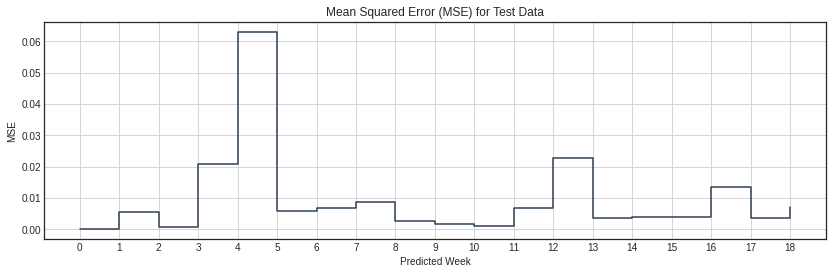

In [12]:
#  Plotting MSE for all evaluated weeks
ax = pd.Series(evaluated_weeks).plot(drawstyle="steps-post",
                                     figsize=(14, 4),
                                     color='#2c3e50',
                                     grid=True,
                                     title='Mean Squared Error (MSE) for Test Data')

ax.set_xticks(range(0, len(evaluated_weeks)))
ax.set_xlabel("Predicted Week")
ax.set_ylabel("MSE")
plt.show()

## Interpreting model results

In [13]:
#  Make predictions for each of the 19 weeks
predicted_weeks = []
for i in range(0, test_data.shape[1]):
    input_series = combined_set[0:, i:i + 76]
    predicted_weeks.append(model.predict(input_series))

In [14]:
#  Flatten `predicted_weeks` to get a list
#  of predictions for each day in the 19 weeks
predicted_days = []
for week in predicted_weeks:
    predicted_days += list(week[0])

In [15]:
#  Creating list of dates associated with predictions
last_day = datetime.strptime(train['date'].max(), '%Y-%m-%d')
list_of_days = []
for days in range(1, len(predicted_days) + 1):
    D = (last_day + timedelta(days=days)).strftime('%Y-%m-%d')
    list_of_days.append(D)

In [16]:
#  Creating dataframe with predicted values
predicted = pd.DataFrame({
    'date': list_of_days,
    'close_point_relative_normalization': predicted_days
})
predicted.head()

,date,close_point_relative_normalization
0,2017-06-25,-0.001523
1,2017-06-26,0.015575
2,2017-06-27,0.065665
3,2017-06-28,0.056139
4,2017-06-29,0.060825


In [17]:
#  Converting `date` variable to datetime
predicted['date'] = predicted['date'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d'))

test['date'] = test['date'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [18]:
def plot_two_series(A, B, variable, title):
    """Plot two series using the same `date` index. 
    
    Parameters
    ----------
    A, B: pd.DataFrame
        Dataframe with a `date` key and a variable
        passed in the `variable` parameter. Parameter A
        represents the "Observed" series and B the "Predicted"
        series. These will be labelled respectively. 
    
    variable: str
        Variable to use in plot.
    
    title: str
        Plot title.
    """
    plt.figure(figsize=(14, 4))
    plt.xlabel('Observed and predicted')

    ax1 = A.set_index('date')[variable].plot(
        color='#d35400', grid=True, label='Observed', title=title)

    ax2 = B.set_index('date')[variable].plot(
        color='grey', grid=True, label='Predicted')
    
    ax1.set_xlabel("Predicted Week")
    ax1.set_ylabel("Predicted Values")

    plt.legend()
    plt.show()

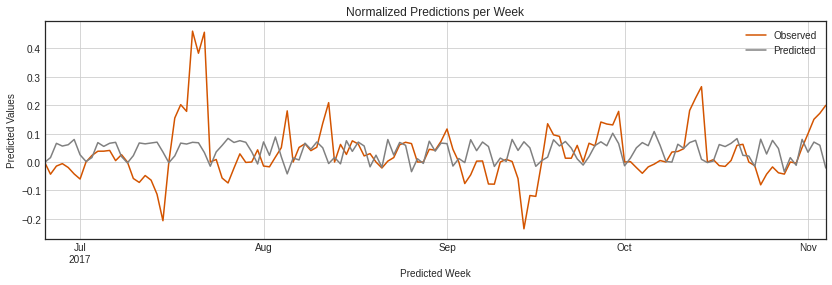

In [19]:
#  Plot predicted normalized prices
#  against actual normalized prices
plot_two_series(A=test[:-3],
                B=predicted,
                variable='close_point_relative_normalization',
                title='Normalized Predictions per Week')

## Denormalize the predictions

In [20]:
#  Add variable `iso_week` by stripping the Year and Week from `date`
predicted['iso_week'] = predicted['date'].apply(
    lambda x: x.strftime('%Y-%U'))

In [21]:
def denormalize(reference, series,
                normalized_variable='close_point_relative_normalization',
                denormalized_variable='close'):
    """Denormalize the values for a given series.

    Parameters
    ----------
    reference: pd.DataFrame
        DataFrame to use as reference. This dataframe
        contains both a week index and the USD price
        reference that we are interested on.

    series: pd.DataFrame
        DataFrame with the predicted series. The
        DataFrame must have the same columns as the
        `reference` dataset.

    normalized_variable: str, default 'close_point_relative_normalization'
        Variable to use in normalization.

    denormalized_variable: str, default `close`
        Variable to use in de-normalization.

    Returns
    -------
    A modified DataFrame with the new variable provided
    in `denormalized_variable` parameter.
    """
    week_values = reference[reference['iso_week'] == series['iso_week'].values[0]]
    last_value = week_values[denormalized_variable].values[0]
    series[denormalized_variable] = last_value * (series[normalized_variable] + 1)

    return series

In [22]:
#  Denormalize predictions
predicted_close = predicted.groupby('iso_week').apply(
    lambda x: denormalize(test[:-3], x))

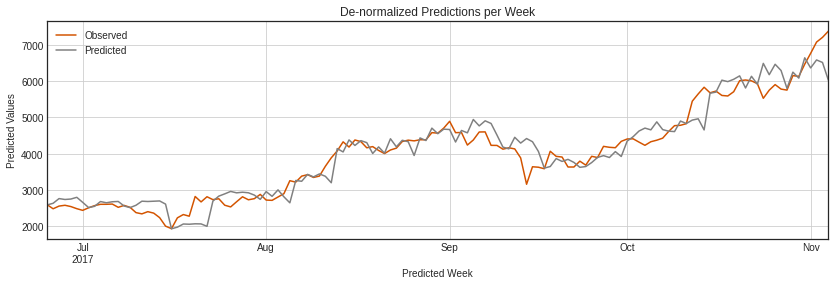

In [23]:
#  Plot denormalized predictions and observed closing prices in test set
plot_two_series(A=test[:-3],
                B=predicted_close,
                variable='close',
                title='De-normalized Predictions per Week')

## Calculate RMSE and MAPE

In [24]:
A = test[:-3]['close_point_relative_normalization']
B = predicted_close['close_point_relative_normalization']

print(f'Normalized RMSE: {rmse(A, B):.2f}')

Normalized RMSE: 0.10


In [25]:
A = test[:-3]['close']
B = predicted_close['close']

print(f'De-normalized RMSE: {rmse(A, B):.2f}')
print(f'De-normalized MAPE: {mape(A, B):.2f}')

De-normalized RMSE: 359.93
De-normalized MAPE: 6.73


## Optimizing the model

In [26]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout, ActivityRegularization

### Reference Model

In [27]:
model_v0 = load_model('bitcoin_lstm_v0.h5')

In [28]:
%%time

#  Retrain network
model_history = train_model(model=model_v0,
            X=X_train, Y=Y_train,
            epochs=100,
            version=0, run_number=0)

Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0029
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 7/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 8/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 11/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 13/100
1/1 [==============================] - 0s 3ms/st

1/1 [==============================] - 0s 2ms/step - loss: 2.2237e-06
CPU times: user 6.12 s, sys: 487 ms, total: 6.61 s
Wall time: 4.81 s


### Adding layers and nodes

In [29]:
#  Initialize variables
period_length = 7
number_of_periods = 76
batch_size = 1

In [30]:
#  Model 1: two LSTM layers
model_v1 = Sequential()

model_v1.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))   
#  Add new LSTM layer to this network here.
#
model_v1.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))


model_v1.add(Dense(units=period_length))
model_v1.add(Activation("linear"))

model_v1.compile(loss="mse", optimizer="rmsprop")

In [31]:
%%time
train_model(model=model_v1, X=X_train, Y=Y_train, epochs=100, version=1, run_number=0)

Epoch 1/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 3/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 9.9799e-04
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 9.1068e-04
Epoch 13/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 2ms/step - loss: 2.0291e-05
CPU times: user 11.8 s, sys: 887 ms, total: 12.7 s
Wall time: 8.26 s


### Epochs

In [32]:
# Model 2: two LSTM layers, trained for 300 epochs
model_v2 = Sequential()

model_v2.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

model_v2.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

model_v2.add(Dense(units=period_length))
model_v2.add(Activation("linear"))

model_v2.compile(loss="mse", optimizer="rmsprop")

In [33]:
%%time
#  The number of epochs set to 300
train_model(model=model_v2, X=X_train, Y=Y_train, epochs=300, version=2, run_number=0)

Epoch 1/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 2/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 3/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 4/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 5/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6/300
1/1 [==============================] - 0s 2ms/step - loss: 9.0346e-04
Epoch 7/300
1/1 [==============================] - 0s 2ms/step - loss: 7.6822e-04
Epoch 8/300
1/1 [==============================] - 0s 2ms/step - loss: 6.5596e-04
Epoch 9/300
1/1 [==============================] - 0s 2ms/step - loss: 5.6173e-04
Epoch 10/300
1/1 [==============================] - 0s 2ms/step - loss: 4.8191e-04
Epoch 11/300
1/1 [==============================] - 0s 2ms/step - loss: 4.1376e-04
Epoch 12/300
1/1 [==============================] - 0s 7ms/step - loss: 3.5513e-04
Epoch 13/300
1/1 [===============

1/1 [==============================] - 0s 2ms/step - loss: 1.3512e-05
Epoch 100/300
1/1 [==============================] - 0s 2ms/step - loss: 8.1811e-06
Epoch 101/300
1/1 [==============================] - 0s 2ms/step - loss: 5.9118e-06
Epoch 102/300
1/1 [==============================] - 0s 2ms/step - loss: 3.9035e-06
Epoch 103/300
1/1 [==============================] - 0s 2ms/step - loss: 3.1696e-06
Epoch 104/300
1/1 [==============================] - 0s 2ms/step - loss: 2.4952e-06
Epoch 105/300
1/1 [==============================] - 0s 2ms/step - loss: 2.2903e-06
Epoch 106/300
1/1 [==============================] - 0s 2ms/step - loss: 2.0680e-06
Epoch 107/300
1/1 [==============================] - 0s 2ms/step - loss: 2.1252e-06
Epoch 108/300
1/1 [==============================] - 0s 2ms/step - loss: 2.1497e-06
Epoch 109/300
1/1 [==============================] - 0s 2ms/step - loss: 2.4465e-06
Epoch 110/300
1/1 [==============================] - 0s 2ms/step - loss: 2.7391e-06
Epoch 

1/1 [==============================] - 0s 2ms/step - loss: 2.6016e-06
Epoch 197/300
1/1 [==============================] - 0s 2ms/step - loss: 2.2706e-06
Epoch 198/300
1/1 [==============================] - 0s 2ms/step - loss: 2.1769e-06
Epoch 199/300
1/1 [==============================] - 0s 2ms/step - loss: 2.2186e-06
Epoch 200/300
1/1 [==============================] - 0s 2ms/step - loss: 2.5858e-06
Epoch 201/300
1/1 [==============================] - 0s 2ms/step - loss: 3.4419e-06
Epoch 202/300
1/1 [==============================] - 0s 2ms/step - loss: 5.2666e-06
Epoch 203/300
1/1 [==============================] - 0s 2ms/step - loss: 8.6512e-06
Epoch 204/300
1/1 [==============================] - 0s 2ms/step - loss: 1.1437e-05
Epoch 205/300
1/1 [==============================] - 0s 2ms/step - loss: 1.1864e-05
Epoch 206/300
1/1 [==============================] - 0s 2ms/step - loss: 8.0536e-06
Epoch 207/300
1/1 [==============================] - 0s 2ms/step - loss: 6.1151e-06
Epoch 

1/1 [==============================] - 0s 6ms/step - loss: 3.3223e-06
Epoch 294/300
1/1 [==============================] - 0s 2ms/step - loss: 5.0228e-06
Epoch 295/300
1/1 [==============================] - 0s 2ms/step - loss: 8.5367e-06
Epoch 296/300
1/1 [==============================] - 0s 2ms/step - loss: 1.0328e-05
Epoch 297/300
1/1 [==============================] - 0s 2ms/step - loss: 9.5982e-06
Epoch 298/300
1/1 [==============================] - 0s 2ms/step - loss: 6.1087e-06
Epoch 299/300
1/1 [==============================] - 0s 2ms/step - loss: 4.3061e-06
Epoch 300/300
1/1 [==============================] - 0s 2ms/step - loss: 3.3345e-06
CPU times: user 26.9 s, sys: 2.67 s, total: 29.5 s
Wall time: 17 s


### Activation functions

In [34]:
# Model 3: two LSTM layers, trained for 300 epochs,
#          tanh activation function
model_v3 = Sequential()

model_v3.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

model_v3.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

model_v3.add(Dense(units=period_length))

model_v3.add(Activation("tanh"))

model_v3.compile(loss="mse", optimizer="rmsprop")

In [35]:
%%time
train_model(model=model_v3, X=X_train, Y=Y_train, epochs=300, version=3, run_number=0)

Epoch 1/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 2/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 3/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 4/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 5/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 6/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 7/300
1/1 [==============================] - 0s 2ms/step - loss: 9.8764e-04
Epoch 8/300
1/1 [==============================] - 0s 2ms/step - loss: 8.2869e-04
Epoch 9/300
1/1 [==============================] - 0s 2ms/step - loss: 6.9344e-04
Epoch 10/300
1/1 [==============================] - 0s 3ms/step - loss: 5.7821e-04
Epoch 11/300
1/1 [==============================] - 0s 4ms/step - loss: 4.8030e-04
Epoch 12/300
1/1 [==============================] - 0s 5ms/step - loss: 3.9759e-04
Epoch 13/300
1/1 [===================

1/1 [==============================] - 0s 2ms/step - loss: 2.2892e-06
Epoch 100/300
1/1 [==============================] - 0s 2ms/step - loss: 2.5241e-06
Epoch 101/300
1/1 [==============================] - 0s 2ms/step - loss: 3.0627e-06
Epoch 102/300
1/1 [==============================] - 0s 2ms/step - loss: 4.0057e-06
Epoch 103/300
1/1 [==============================] - 0s 2ms/step - loss: 5.6379e-06
Epoch 104/300
1/1 [==============================] - 0s 3ms/step - loss: 8.4695e-06
Epoch 105/300
1/1 [==============================] - 0s 2ms/step - loss: 1.0009e-05
Epoch 106/300
1/1 [==============================] - 0s 3ms/step - loss: 8.5901e-06
Epoch 107/300
1/1 [==============================] - 0s 2ms/step - loss: 4.7612e-06
Epoch 108/300
1/1 [==============================] - 0s 2ms/step - loss: 2.8394e-06
Epoch 109/300
1/1 [==============================] - 0s 2ms/step - loss: 1.7125e-06
Epoch 110/300
1/1 [==============================] - 0s 2ms/step - loss: 1.3815e-06
Epoch 

1/1 [==============================] - 0s 2ms/step - loss: 3.4665e-06
Epoch 197/300
1/1 [==============================] - 0s 2ms/step - loss: 4.0111e-06
Epoch 198/300
1/1 [==============================] - 0s 2ms/step - loss: 4.9215e-06
Epoch 199/300
1/1 [==============================] - 0s 4ms/step - loss: 5.5937e-06
Epoch 200/300
1/1 [==============================] - 0s 5ms/step - loss: 5.4749e-06
Epoch 201/300
1/1 [==============================] - 0s 4ms/step - loss: 5.1070e-06
Epoch 202/300
1/1 [==============================] - 0s 2ms/step - loss: 4.3298e-06
Epoch 203/300
1/1 [==============================] - 0s 4ms/step - loss: 3.8889e-06
Epoch 204/300
1/1 [==============================] - 0s 4ms/step - loss: 3.1380e-06
Epoch 205/300
1/1 [==============================] - 0s 6ms/step - loss: 2.7200e-06
Epoch 206/300
1/1 [==============================] - 0s 6ms/step - loss: 2.1862e-06
Epoch 207/300
1/1 [==============================] - 0s 2ms/step - loss: 1.9721e-06
Epoch 

1/1 [==============================] - 0s 2ms/step - loss: 3.5952e-06
Epoch 294/300
1/1 [==============================] - 0s 2ms/step - loss: 3.0292e-06
Epoch 295/300
1/1 [==============================] - 0s 2ms/step - loss: 2.4969e-06
Epoch 296/300
1/1 [==============================] - 0s 2ms/step - loss: 2.4225e-06
Epoch 297/300
1/1 [==============================] - 0s 2ms/step - loss: 2.4148e-06
Epoch 298/300
1/1 [==============================] - 0s 2ms/step - loss: 2.7282e-06
Epoch 299/300
1/1 [==============================] - 0s 2ms/step - loss: 3.1670e-06
Epoch 300/300
1/1 [==============================] - 0s 2ms/step - loss: 3.7382e-06
CPU times: user 27.9 s, sys: 2.84 s, total: 30.8 s
Wall time: 18.3 s


### Regularization strategies

In [36]:
model_v4 = Sequential()
model_v4.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

#  Implementing a Dropout()
model_v4.add(Dropout(0.2))

model_v4.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

#  Implementing a Dropout() here too.
model_v4.add(Dropout(0.2))

model_v4.add(Dense(units=period_length))
model_v4.add(Activation("tanh"))

model_v4.compile(loss="mse", optimizer="rmsprop")

In [37]:
%%time
train_model(model=model_v4, X=X_train, Y=Y_train, epochs=600, version=4, run_number=0)

Epoch 1/600
1/1 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 2/600
1/1 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 3/600
1/1 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 4/600
1/1 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 5/600
1/1 [==============================] - 0s 2ms/step - loss: 6.5808e-04
Epoch 6/600
1/1 [==============================] - 0s 2ms/step - loss: 8.9027e-04
Epoch 7/600
1/1 [==============================] - 0s 2ms/step - loss: 4.3345e-04
Epoch 8/600
1/1 [==============================] - 0s 3ms/step - loss: 9.8639e-04
Epoch 9/600
1/1 [==============================] - 0s 3ms/step - loss: 4.8590e-04
Epoch 10/600
1/1 [==============================] - 0s 2ms/step - loss: 5.2229e-04
Epoch 11/600
1/1 [==============================] - 0s 2ms/step - loss: 3.0122e-04
Epoch 12/600
1/1 [==============================] - 0s 3ms/step - loss: 4.4985e-04
Epoch 13/600
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 3.4141e-05
Epoch 101/600
1/1 [==============================] - 0s 2ms/step - loss: 9.3877e-06
Epoch 102/600
1/1 [==============================] - 0s 2ms/step - loss: 9.1198e-06
Epoch 103/600
1/1 [==============================] - 0s 2ms/step - loss: 7.9217e-05
Epoch 104/600
1/1 [==============================] - 0s 2ms/step - loss: 4.3796e-05
Epoch 105/600
1/1 [==============================] - 0s 2ms/step - loss: 5.3095e-05
Epoch 106/600
1/1 [==============================] - 0s 2ms/step - loss: 4.8290e-06
Epoch 107/600
1/1 [==============================] - 0s 2ms/step - loss: 6.1816e-05
Epoch 108/600
1/1 [==============================] - 0s 2ms/step - loss: 4.3760e-05
Epoch 109/600
1/1 [==============================] - 0s 2ms/step - loss: 6.0519e-05
Epoch 110/600
1/1 [==============================] - 0s 3ms/step - loss: 9.7450e-05
Epoch 111/600
1/1 [==============================] - 0s 2ms/step - loss: 1.7220e-04
Epoch 

1/1 [==============================] - 0s 3ms/step - loss: 1.2350e-06
Epoch 198/600
1/1 [==============================] - 0s 5ms/step - loss: 3.3677e-06
Epoch 199/600
1/1 [==============================] - 0s 3ms/step - loss: 3.9484e-06
Epoch 200/600
1/1 [==============================] - 0s 2ms/step - loss: 2.0446e-06
Epoch 201/600
1/1 [==============================] - 0s 2ms/step - loss: 2.7908e-06
Epoch 202/600
1/1 [==============================] - 0s 2ms/step - loss: 4.7050e-06
Epoch 203/600
1/1 [==============================] - 0s 2ms/step - loss: 1.9264e-06
Epoch 204/600
1/1 [==============================] - 0s 2ms/step - loss: 3.4977e-06
Epoch 205/600
1/1 [==============================] - 0s 2ms/step - loss: 6.5032e-06
Epoch 206/600
1/1 [==============================] - 0s 2ms/step - loss: 8.9356e-06
Epoch 207/600
1/1 [==============================] - 0s 6ms/step - loss: 6.1433e-06
Epoch 208/600
1/1 [==============================] - 0s 4ms/step - loss: 2.5010e-05
Epoch 

1/1 [==============================] - 0s 2ms/step - loss: 1.8958e-06
Epoch 295/600
1/1 [==============================] - 0s 2ms/step - loss: 5.2687e-06
Epoch 296/600
1/1 [==============================] - 0s 2ms/step - loss: 4.7442e-06
Epoch 297/600
1/1 [==============================] - 0s 2ms/step - loss: 8.7604e-06
Epoch 298/600
1/1 [==============================] - 0s 2ms/step - loss: 8.0007e-06
Epoch 299/600
1/1 [==============================] - 0s 2ms/step - loss: 8.2879e-06
Epoch 300/600
1/1 [==============================] - 0s 2ms/step - loss: 9.7458e-06
Epoch 301/600
1/1 [==============================] - 0s 2ms/step - loss: 2.3956e-06
Epoch 302/600
1/1 [==============================] - 0s 2ms/step - loss: 1.3881e-05
Epoch 303/600
1/1 [==============================] - 0s 2ms/step - loss: 2.2435e-06
Epoch 304/600
1/1 [==============================] - 0s 2ms/step - loss: 4.0788e-07
Epoch 305/600
1/1 [==============================] - 0s 2ms/step - loss: 2.9288e-06
Epoch 

1/1 [==============================] - 0s 2ms/step - loss: 3.6955e-06
Epoch 392/600
1/1 [==============================] - 0s 2ms/step - loss: 2.6856e-06
Epoch 393/600
1/1 [==============================] - 0s 2ms/step - loss: 4.5650e-06
Epoch 394/600
1/1 [==============================] - 0s 2ms/step - loss: 3.4053e-06
Epoch 395/600
1/1 [==============================] - 0s 2ms/step - loss: 3.5003e-06
Epoch 396/600
1/1 [==============================] - 0s 2ms/step - loss: 4.6546e-06
Epoch 397/600
1/1 [==============================] - 0s 2ms/step - loss: 3.6692e-06
Epoch 398/600
1/1 [==============================] - 0s 2ms/step - loss: 5.2896e-06
Epoch 399/600
1/1 [==============================] - 0s 3ms/step - loss: 1.3870e-06
Epoch 400/600
1/1 [==============================] - 0s 5ms/step - loss: 3.6070e-06
Epoch 401/600
1/1 [==============================] - 0s 2ms/step - loss: 3.4315e-06
Epoch 402/600
1/1 [==============================] - 0s 3ms/step - loss: 1.7515e-06
Epoch 

1/1 [==============================] - 0s 2ms/step - loss: 7.1115e-07
Epoch 489/600
1/1 [==============================] - 0s 2ms/step - loss: 1.6427e-06
Epoch 490/600
1/1 [==============================] - 0s 2ms/step - loss: 1.2282e-06
Epoch 491/600
1/1 [==============================] - 0s 2ms/step - loss: 2.5267e-06
Epoch 492/600
1/1 [==============================] - 0s 5ms/step - loss: 2.3602e-06
Epoch 493/600
1/1 [==============================] - 0s 5ms/step - loss: 1.3340e-07
Epoch 494/600
1/1 [==============================] - 0s 2ms/step - loss: 1.1269e-06
Epoch 495/600
1/1 [==============================] - 0s 3ms/step - loss: 3.0254e-06
Epoch 496/600
1/1 [==============================] - 0s 2ms/step - loss: 6.0801e-06
Epoch 497/600
1/1 [==============================] - 0s 3ms/step - loss: 1.9484e-06
Epoch 498/600
1/1 [==============================] - 0s 2ms/step - loss: 1.4106e-06
Epoch 499/600
1/1 [==============================] - 0s 2ms/step - loss: 1.1381e-06
Epoch 

1/1 [==============================] - 0s 3ms/step - loss: 1.9492e-07
Epoch 586/600
1/1 [==============================] - 0s 4ms/step - loss: 1.9689e-06
Epoch 587/600
1/1 [==============================] - 0s 3ms/step - loss: 1.8906e-06
Epoch 588/600
1/1 [==============================] - 0s 3ms/step - loss: 1.8814e-06
Epoch 589/600
1/1 [==============================] - 0s 4ms/step - loss: 1.5080e-06
Epoch 590/600
1/1 [==============================] - 0s 3ms/step - loss: 1.9451e-06
Epoch 591/600
1/1 [==============================] - 0s 6ms/step - loss: 1.4188e-06
Epoch 592/600
1/1 [==============================] - 0s 2ms/step - loss: 1.0372e-06
Epoch 593/600
1/1 [==============================] - 0s 2ms/step - loss: 3.0691e-06
Epoch 594/600
1/1 [==============================] - 0s 5ms/step - loss: 3.9845e-06
Epoch 595/600
1/1 [==============================] - 0s 2ms/step - loss: 4.8244e-07
Epoch 596/600
1/1 [==============================] - 0s 3ms/step - loss: 1.4678e-06
Epoch 

### Evaluate models

In [38]:
combined_set = np.concatenate((train_data, test_data), axis=1)

def evaluate_model(model, kind='series'):
    """Compute the MSE for all future weeks in period.
    
    Parameters
    ----------
    model: Keras trained model
    
    kind: str, default 'series'
        Kind of evaluation to perform. If 'series', 
        then the model will perform an evaluation 
        over the complete series.
    
    Returns
    -------
    evaluated_weeks: list
        List of MSE values for each evaluated
        test week.
    """
    if kind == 'series':
        predicted_weeks = []
        for i in range(0, test_data.shape[1]):
            input_series = combined_set[0:,i:i+76]
            predicted_weeks.append(model.predict(input_series))

        predicted_days = []
        for week in predicted_weeks:
            predicted_days += list(week[0])

        return predicted_days
    else:
        evaluated_weeks = []
        for i in range(0, test_data.shape[1]):
            input_series = combined_set[0:,i:i+77]

            X_test = input_series[0:,:-1].reshape(1, input_series.shape[1] - 1, 7)
            Y_test = input_series[0:,-1:][0]

            result = model.evaluate(x=X_test, y=Y_test, verbose=0)
            evaluated_weeks.append(result)
            
            return evaluated_weeks


In [39]:
def plot_weekly_mse(series, model_name, color):
    """Plot weekly MSE."""
    ax = pd.Series(series).plot(drawstyle="steps-post",
                                figsize=(14,4),
                                color=color,
                                grid=True,
                                label=model_name,
                                alpha=0.7,
                                title='Mean Squared Error (MSE) for Test Data (all models)'.format(
                                       model_name))

    ax.set_xticks(range(0, len(series)))
    ax.set_xlabel("Predicted Week")
    ax.set_ylabel("MSE")

    return ax

In [40]:
def plot_weekly_predictions(predicted_days, name, display_plot=True, 
                            variable='close'):
    """Plot weekly predictions and calculate RMSE and MAPE."""
    
    # Create dataframe to store predictions and associated dates
    last_day = datetime.strptime(train['date'].max(), '%Y-%m-%d')
    list_of_days = []
    for days in range(1, len(predicted_days) + 1):
        D = (last_day + timedelta(days=days)).strftime('%Y-%m-%d')
        list_of_days.append(D)
    
    predicted = pd.DataFrame({
        'date': list_of_days,
        'close_point_relative_normalization': predicted_days
    })
    
    # Convert `date` variable to datetime
    predicted['date'] = predicted['date'].apply(
        lambda x: datetime.strptime(x, '%Y-%m-%d'))

    # Create iso_week column in `predicted` dataframe
    predicted['iso_week'] = predicted['date'].apply(
        lambda x: x.strftime('%Y-%U'))

    # Denormalize predictions
    predicted_close = predicted.groupby('iso_week').apply(
        lambda x: denormalize(test[:-3], x))

    # Plot denormalized predictions and observed values
    plot_two_series(test[:-3], predicted_close,
                    variable=variable,
                    title=f'{name}: Predictions per Week')
    
    # Calculate RMSE and MAPE
    print(f'RMSE: {rmse(test[:-3][variable], predicted_close[variable]):.2f}')
    print(f'MAPE: {mape(test[:-3][variable], predicted_close[variable]):.2f}%')

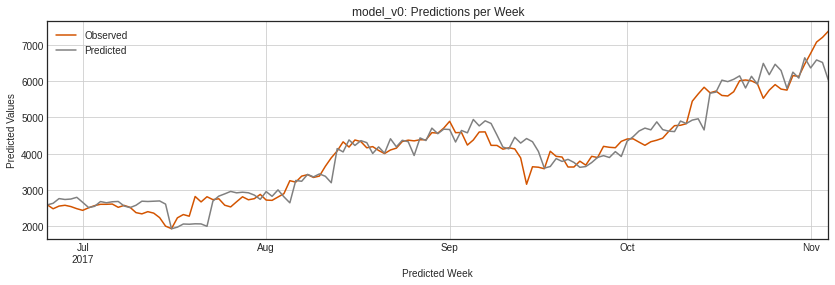

RMSE: 359.93
MAPE: 6.73%


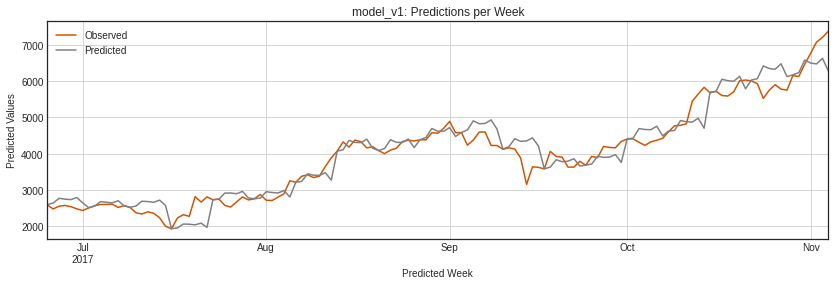

RMSE: 353.68
MAPE: 6.57%


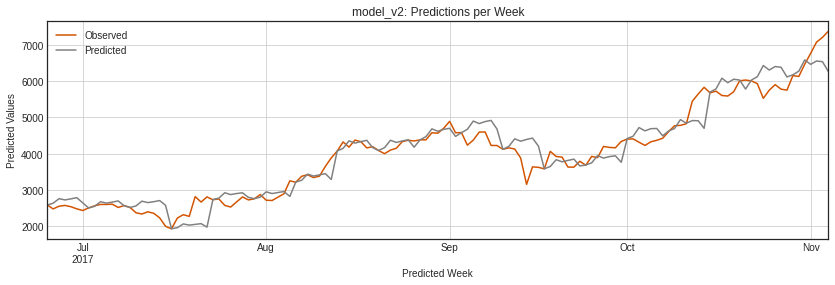

RMSE: 353.65
MAPE: 6.52%


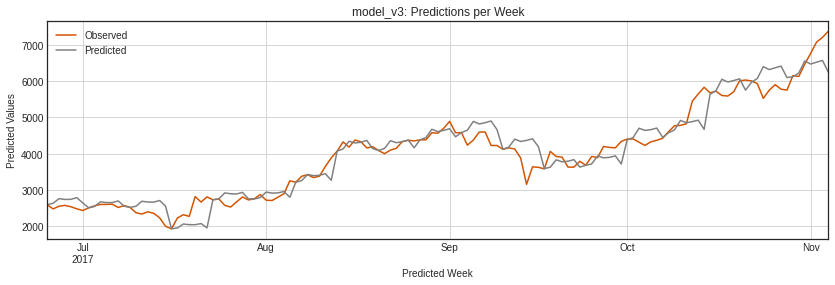

RMSE: 352.73
MAPE: 6.47%


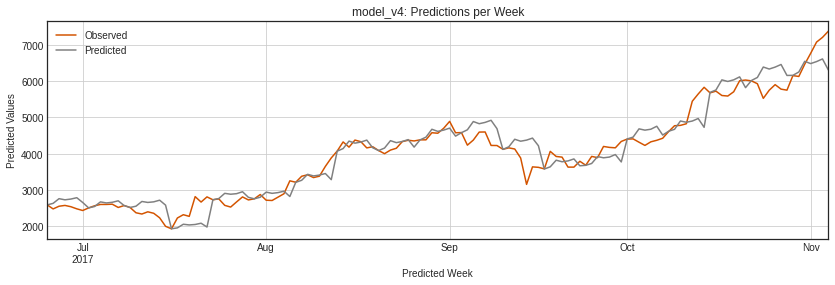

RMSE: 349.59
MAPE: 6.46%


In [41]:
#  Evaluate each model trained in sequence
models = [model_v0, model_v1, model_v2, model_v3, model_v4]
for i, M in enumerate(models):
    predicted_days = evaluate_model(M, kind='series')
    plot_weekly_predictions(predicted_days, f'model_v{i}')

### Result
Interestingly, basic model model_v0 performed better than model_v1 and model_v4 in all defined metrics, and not significantly worse than model_v2 and model_v3.